# NuClick:Interactive Annotation for Pathology

### Inference Notebook

In [20]:
!python -c "import cv2" || pip install -q opencv-python-headless==4.5.5.64
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [1]:
from monai.apps.nuclick.transforms import (
    FlattenLabeld,
    ExtractPatchd,
    SplitLabeld,
    AddPointGuidanceSignald,
    FilterImaged
)
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    Compose,
    EnsureTyped,
    LoadImaged,
    LoadImage,
    RandRotate90d,
    ScaleIntensityRangeD,
    ToNumpyd,
    TorchVisiond,
    ToTensord,
)
from monai.data import (
    Dataset,
    DataLoader,
    MetaTensor
)
from monai.networks.nets import BasicUNet
from skimage.measure import regionprops
import json
import copy
import math
import os
import numpy as np
import cv2
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]

/localhome/sachi/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utility Functions

`split_nuclei_dataset` for all the per label splits, there can be multiple nuclei in the given patch, this particular function provides the centroid of the image and also selects a single nuclei for a single training pair and the other nuclei get masked out

In [2]:
def split_nuclei_dataset(d, centroid_key="centroid", mask_value_key="mask_value", min_area=5):
    dataset_json = []

    mask = LoadImage(image_only=True, dtype=np.uint8)(d["label"])
    _, labels, _, _ = cv2.connectedComponentsWithStats(mask.array if isinstance(mask, MetaTensor) else mask, 4, cv2.CV_32S)
    stats = regionprops(labels)
    for stat in stats:
        if stat.area < min_area:
            print(f"++++ Ignored label with smaller area => ( {stat.area} < {min_area})")
            continue

        x, y = stat.centroid
        x = int(math.floor(x))
        y = int(math.floor(y))

        item = copy.deepcopy(d)
        item[centroid_key] = (x, y)
        item[mask_value_key] = stat.label

        dataset_json.append(item)
    return dataset_json

## Define Model Path for Inference

Since we are using the pre-processed data for the inference, the section "Create Json, form training and validation split" of the training notebook needs to be executed in order for the pre-processed data to be used here

Also configure `model_weights_path` to the best saved validation metric model file name.

A set of pre-trained weights are available for download at this link:https://drive.google.com/file/d/1ZVrLHyoAQLaATt4XEWGPUhnDFoK0og7x/view?usp=sharing

In [3]:
# Add the code paths here
logging_dir = os.path.normpath('/localhome/sachi/Downloads/PanNuke/test_trial/')

dataset_path = os.path.join(logging_dir, 'data')
json_path = os.path.join(logging_dir, 'data_list.json')
model_weights_path = os.path.join(logging_dir, 'network_key_metric=0.2069.pt')

In [4]:
patch_size = 128
min_area = 5
val_transforms = Compose(
    [
        LoadImaged(keys=("image", "label"), dtype=np.uint8),
        FilterImaged(keys="image", min_size=5),
        FlattenLabeld(keys="label"),
        AsChannelFirstd(keys="image"),
        AddChanneld(keys="label"),
        ExtractPatchd(keys=("image", "label"), patch_size=patch_size),
        SplitLabeld(keys="label", others="others", mask_value="mask_value", min_area=min_area),
        ToTensord(keys="image"),
        TorchVisiond(
            keys="image", name="ColorJitter", brightness=64.0 / 255.0, contrast=0.75, saturation=0.25, hue=0.04
        ),
        ToNumpyd(keys="image"),
        RandRotate90d(keys=("image", "label", "others"), prob=0.5, spatial_axes=(0, 1)),
        ScaleIntensityRangeD(keys="image", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
        AddPointGuidanceSignald(image="image", label="label", others="others", drop_rate=1.0),
        EnsureTyped(keys=("image", "label"))
    ]
)

<class 'monai.transforms.utility.array.AsChannelFirst'>: Class `AsChannelFirst` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


In [5]:
device = torch.device("cuda")

network = BasicUNet(
    spatial_dims=2,
    in_channels=5,
    out_channels=1,
    features=(32, 64, 128, 256, 512, 32),
)

# The saved weights is a state_dict already
model_weights = torch.load(model_weights_path)
# print(model_weights)
network.load_state_dict(model_weights)
network.to(device)

BasicUNet features: (32, 64, 128, 256, 512, 32).


BasicUNet(
  (conv_0): TwoConv(
    (conv_0): Convolution(
      (conv): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (conv_1): Convolution(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
  )
  (down_1): Down(
    (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convs): TwoConv(
      (conv_0): Convolution(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): InstanceNorm2

In [6]:
# Load the json file and get a couple of samples for inferencing
with open(json_path, 'rb') as j_file:
    json_data = json.load(j_file)
j_file.close()

test_data = json_data[0:1]

test_data_list = []
for d in tqdm(test_data):
    test_data_list.extend(split_nuclei_dataset(d, min_area=min_area))

test_ds = Dataset(data=test_data_list,
                  transform=val_transforms,
                  )

test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 132.89it/s]


## Per transform visualization for how the data gets prepared for inference

Note: For AddGuidanceSignal plot, the marker shows up in yellow color and in some instances becomes hard to see due to random augmentations, if not visible please run the below snippet of code again

Transform: LoadImaged, image shape: torch.Size([256, 256, 3]), label shape: torch.Size([256, 256])
torch.Size([256, 256, 3])


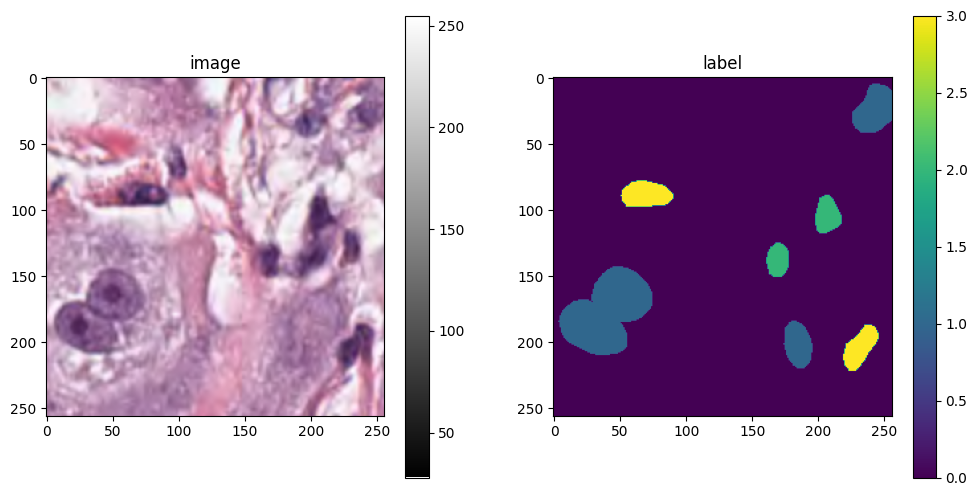

dict_keys(['image', 'label', 'centroid', 'mask_value', 'image_meta_dict', 'label_meta_dict'])
#############
Transform: FilterImaged, image shape: (256, 256, 3), label shape: torch.Size([256, 256])
(256, 256, 3)


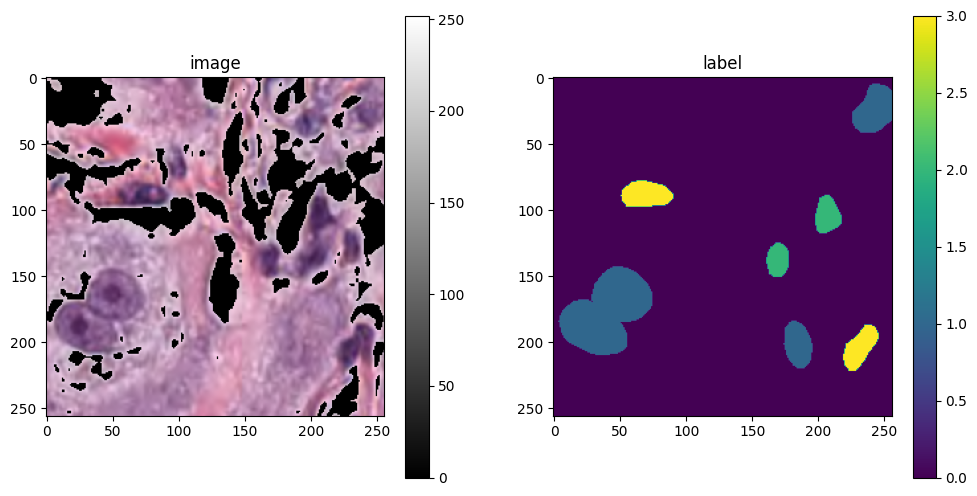

dict_keys(['image', 'label', 'centroid', 'mask_value', 'image_meta_dict', 'label_meta_dict'])
#############
Transform: FlattenLabeld, image shape: (256, 256, 3), label shape: (256, 256)
(256, 256, 3)


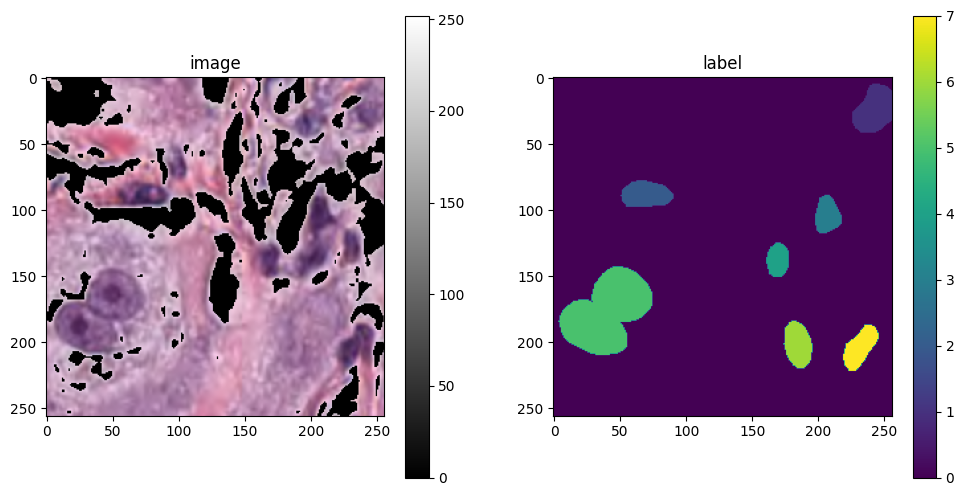

dict_keys(['image', 'label', 'centroid', 'mask_value', 'image_meta_dict', 'label_meta_dict'])
#############
Transform: AsChannelFirstd, image shape: torch.Size([3, 256, 256]), label shape: (256, 256)
Channel Shifted or added to first no difference in image
#############
Transform: AddChanneld, image shape: torch.Size([3, 256, 256]), label shape: torch.Size([1, 256, 256])
Channel Shifted or added to first no difference in image
#############
Transform: ExtractPatchd, image shape: torch.Size([3, 128, 128]), label shape: torch.Size([1, 128, 128])
torch.Size([3, 128, 128])
3


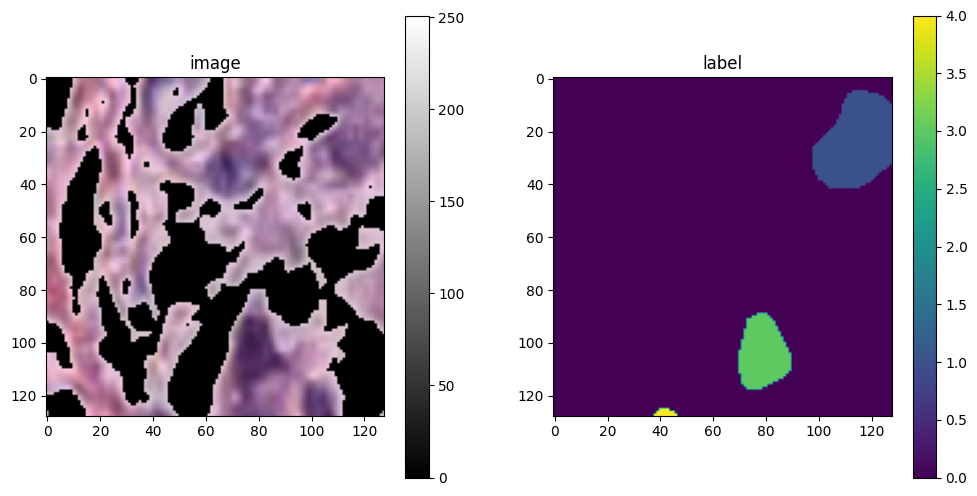

dict_keys(['image', 'label', 'centroid', 'mask_value', 'image_meta_dict', 'label_meta_dict'])
#############
Transform: SplitLabeld, image shape: torch.Size([3, 128, 128]), label shape: torch.Size([1, 128, 128])
torch.Size([3, 128, 128])
3


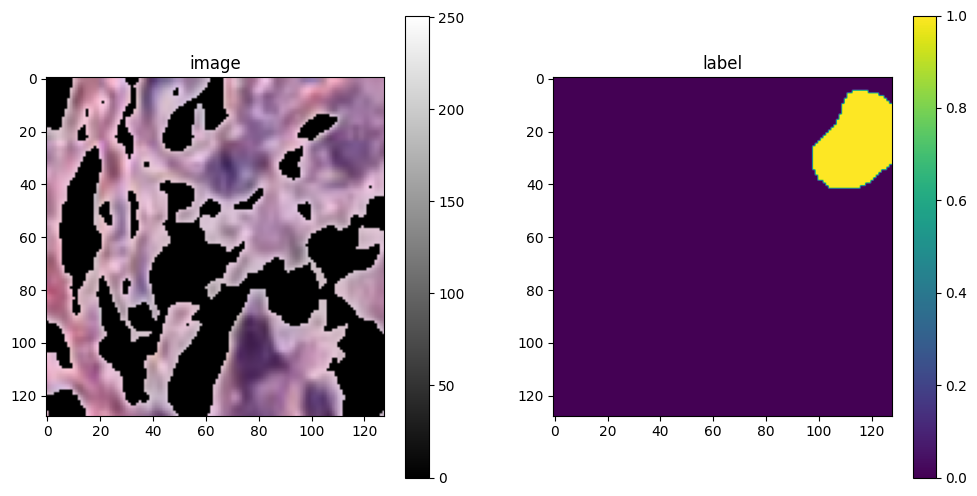

dict_keys(['image', 'label', 'centroid', 'mask_value', 'image_meta_dict', 'label_meta_dict', 'others'])
#############
Transform: ToTensord, image shape: torch.Size([3, 128, 128]), label shape: torch.Size([1, 128, 128])
Skipping because of torch tensors
#############
Transform: TorchVisiond, image shape: torch.Size([3, 128, 128]), label shape: torch.Size([1, 128, 128])
Skipping because of torch tensors
#############
Transform: ToNumpyd, image shape: (3, 128, 128), label shape: torch.Size([1, 128, 128])
(3, 128, 128)
3


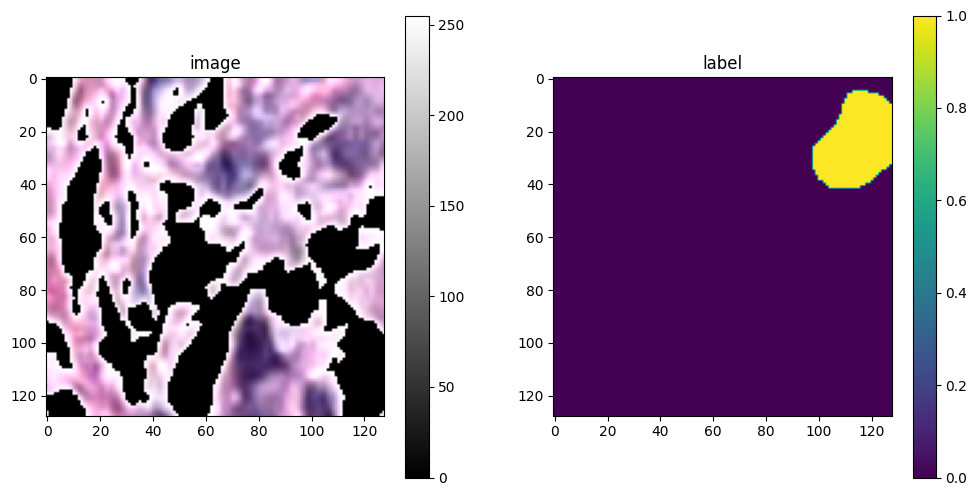

dict_keys(['image', 'label', 'centroid', 'mask_value', 'image_meta_dict', 'label_meta_dict', 'others'])
#############
Transform: RandRotate90d, image shape: torch.Size([3, 128, 128]), label shape: torch.Size([1, 128, 128])
torch.Size([3, 128, 128])
3


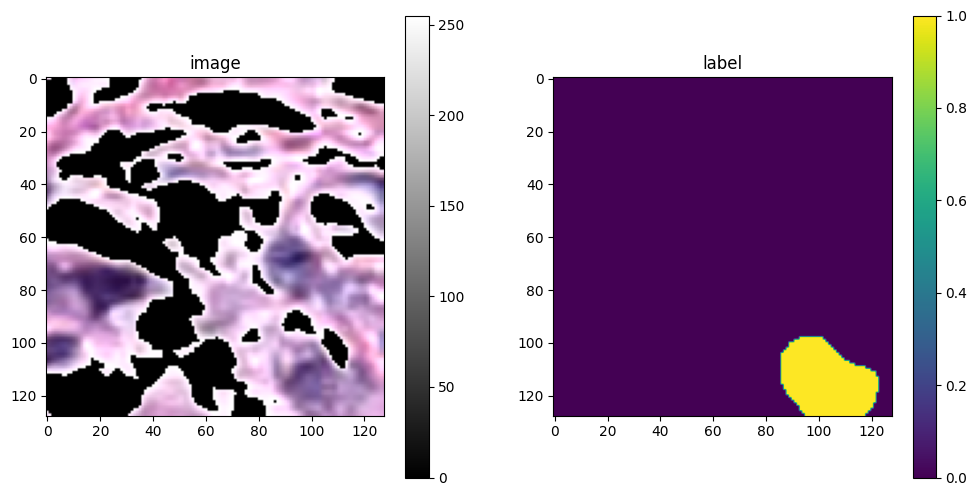

dict_keys(['image', 'label', 'centroid', 'mask_value', 'image_meta_dict', 'label_meta_dict', 'others'])
#############
Transform: ScaleIntensityRanged, image shape: torch.Size([3, 128, 128]), label shape: torch.Size([1, 128, 128])
torch.Size([3, 128, 128])
3
2022-11-22 19:09:48,217 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


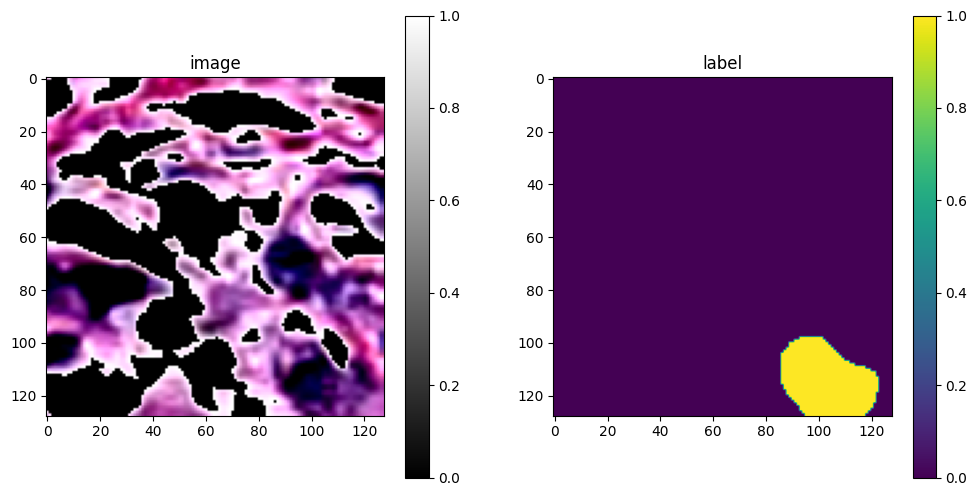

dict_keys(['image', 'label', 'centroid', 'mask_value', 'image_meta_dict', 'label_meta_dict', 'others'])
#############
Transform: AddPointGuidanceSignald, image shape: torch.Size([5, 128, 128]), label shape: torch.Size([1, 128, 128])
torch.Size([5, 128, 128])
2022-11-22 19:09:48,807 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[[108  94]]
[]


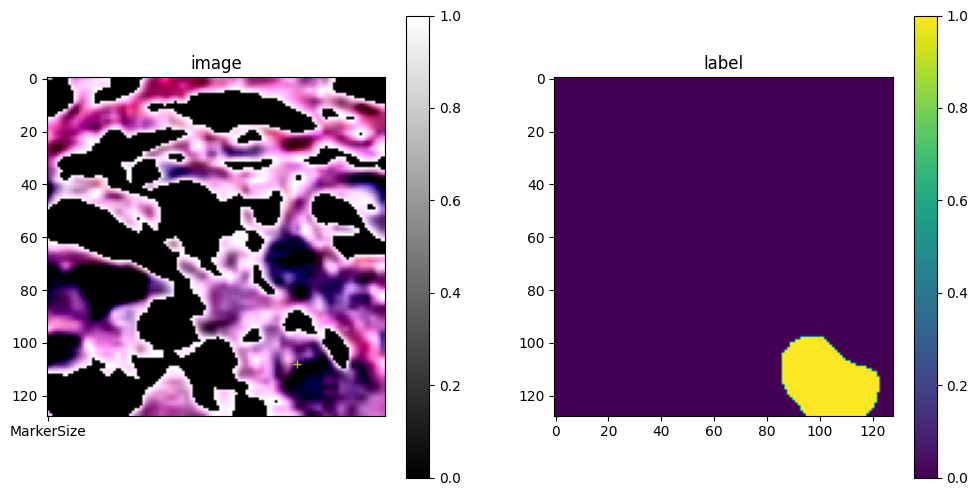

dict_keys(['image', 'label', 'centroid', 'mask_value', 'image_meta_dict', 'label_meta_dict', 'others'])
#############
Transform: EnsureTyped, image shape: torch.Size([5, 128, 128]), label shape: torch.Size([1, 128, 128])
This transformation is for ensuring data types
#############


In [7]:
def show_image(image, label):
    img_dims = image.shape
    print(img_dims)

    if img_dims[0] == 3:
        print(img_dims[0])
        image = np.moveaxis(image, 0, 2)
        label = np.moveaxis(label, 0, 2)

    if img_dims[0] == 5:
        image = np.moveaxis(image, 0, 2)
        label = np.moveaxis(label, 0, 2)
        p_guidance_map = image[:, :, 3]
        n_guidance_map = image[:, :, 4]
        image = image[:, :, :3]

    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap="gray")

    if img_dims[0] == 5:
        p_guide_point = np.argwhere(p_guidance_map == 1)
        n_guide_point = np.argwhere(n_guidance_map == 1)
        guide_point = [p_guide_point, n_guide_point]
        draw_points(guide_point)

    plt.colorbar()

    if label is not None:
        plt.subplot(1, 2, 2)
        plt.title("label")
        plt.imshow(label)
        plt.colorbar()
    plt.show()


def draw_points(guidance):
    if guidance is None:
        return
    colors = ['y+', 'b+']
    for color, points in zip(colors, guidance):
        print(points)
        for p in points:
            p1 = p[1]
            p2 = p[0]
            plt.plot(p1, p2, color, 'MarkerSize', 120)


val_demo_transforms = [
    LoadImaged(keys=("image", "label"), dtype=np.uint8),
    FilterImaged(keys="image", min_size=5),
    FlattenLabeld(keys="label"),
    AsChannelFirstd(keys="image"),
    AddChanneld(keys="label"),
    ExtractPatchd(keys=("image", "label"), patch_size=patch_size),
    SplitLabeld(keys="label", others="others", mask_value="mask_value", min_area=min_area),
    ToTensord(keys="image"),
    TorchVisiond(
        keys="image", name="ColorJitter", brightness=64.0 / 255.0, contrast=0.75, saturation=0.25, hue=0.04
    ),
    ToNumpyd(keys="image"),
    RandRotate90d(keys=("image", "label", "others"), prob=0.5, spatial_axes=(0, 1)),
    ScaleIntensityRangeD(keys="image", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
    AddPointGuidanceSignald(image="image", label="label", others="others", drop_rate=1.0),
    EnsureTyped(keys=("image", "label"))
]


test_data = test_data_list[0]

for t in val_demo_transforms:
    tname = type(t).__name__
    test_data = t(test_data)

    image = test_data['image']
    label = test_data.get('label')

    print('Transform: {}, image shape: {}, label shape: {}'.format(tname, image.shape, label.shape))
    if tname == 'AsChannelFirstd' or tname == 'AddChanneld':
        print('Channel Shifted or added to first no difference in image')
    elif tname == 'ToTensord' or tname == 'TorchVisiond':
        print('Skipping because of torch tensors')
    elif tname == 'EnsureTyped':
        print('This transformation is for ensuring data types')
    else:
        show_image(image, label)
        print(test_data.keys())
    print('#############')

## Inference example using the transforms with a prediction from the network

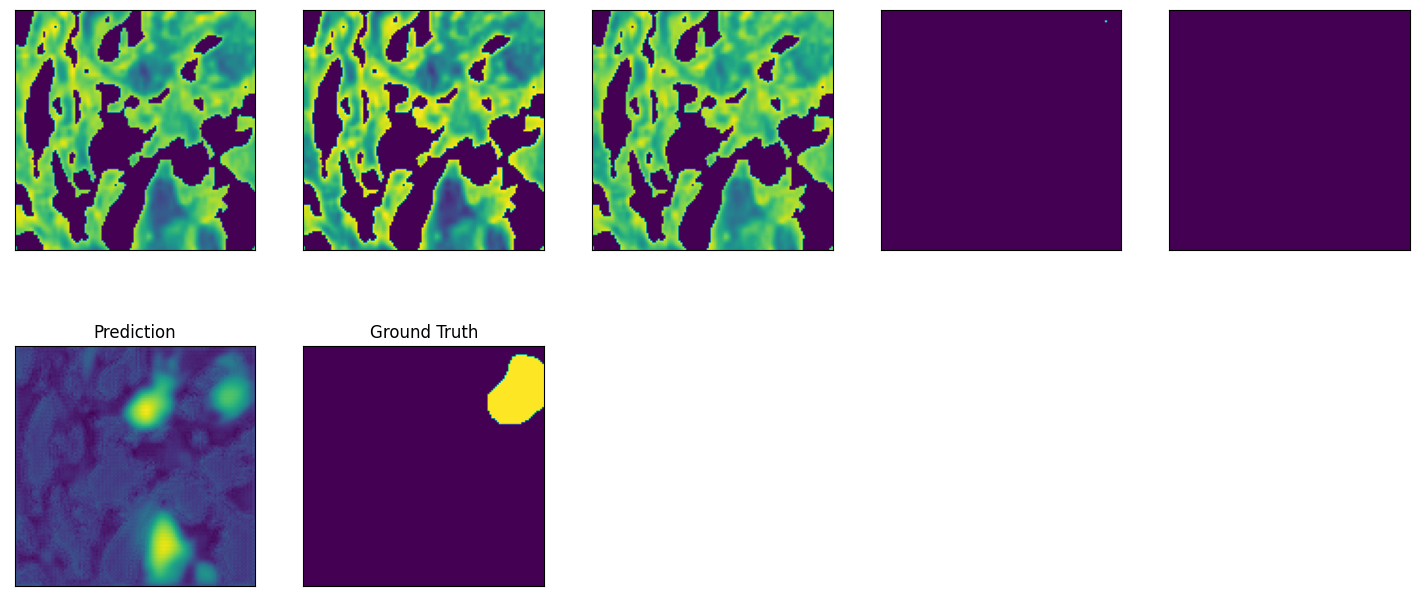

In [8]:
network.eval()
with torch.no_grad():
    for step, batch in enumerate(test_loader):

        batch['image'] = batch['image'].to(device)
        pred = network(batch['image'])

        image = batch['image'].to('cpu').numpy()
        for plt_img in range(1, 6):
            plt.subplot(2, 5, plt_img)
            plt.imshow(np.squeeze(image[0, plt_img - 1, :, :]))
            plt.xticks([])
            plt.yticks([])

        plt.subplot(2, 5, 6)
        pred = pred.to('cpu').numpy()
        plt.imshow(pred[0, 0, :, :])
        plt.xticks([])
        plt.yticks([])
        plt.title('Prediction')

        plt.subplot(2, 5, 7)
        label = batch['label'].to('cpu').numpy()
        plt.imshow(label[0, 0, :, :])
        plt.xticks([])
        plt.yticks([])
        plt.title('Ground Truth')

        break

## End of Notebook